# R&D Capital Replication

Ziyu Wang (zw5565)

In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from sklearn.model_selection import train_test_split

use `LPERMNO` as the unique identifier

`funda`: annual fundamental from CRSP/Compustat Merged. Already included the following filters:
1. fic = 'USA'
2. curncd = 'USD'
3. exchg $\in$ [11,19]

`secm`: security monthly from CRSP/Compustat Merged. Already included the following filters:
1. fic = 'USA'
2. exchg $\in$ [11,19]

In [3]:
funda = pd.read_csv('hw1_funda.csv')
secm = pd.read_csv('hw1_secm.csv')

In [4]:
f = [len(funda), funda.fic.value_counts().to_dict(), funda.curncd.value_counts().to_dict(), \
     (funda.sic.min(), funda.sic.max()), (funda.exchg.min(), funda.exchg.max())]
s = [len(secm), secm.fic.value_counts().to_dict(), np.nan, \
     (secm.sic.min(), secm.sic.max()), (secm.exchg.min(), secm.exchg.max())]
a = pd.DataFrame(columns=['size','fic','curncd','sic','exchg'], index=['funda','secm'])
a.loc['funda'] = f
a.loc['secm'] = s
a

,size,fic,curncd,sic,exchg
funda,244966,{'USA': 244966},{'USD': 244966},"(100.0, 9997.0)","(11, 19)"
secm,2815162,{'USA': 2815162},NaN,"(100.0, 9997.0)","(11, 19)"


#### Fundamental Annual

In [5]:
funda['datadate'] = pd.to_datetime(funda['datadate'])
mask1 = funda['sic'].isin([x for x in range(6000,7000)])
funda = funda[~mask1]
funda = funda[['datadate','LPERMNO','xrd','mkvalt','prcc_f','csho']]

In [6]:
# sorting R&D variables
def shift_xrd(series):
    return series + 0.8*series.shift(1) + 0.6*series.shift(2) + 0.4*series.shift(3) + 0.2*series.shift(4)

In [7]:
funda

,datadate,LPERMNO,xrd,mkvalt,prcc_f,csho
0,1976-12-31,25881,NaN,NaN,5.7500,2.207
1,1977-12-31,25881,NaN,NaN,9.2500,2.226
2,1983-12-31,10015,0.000,NaN,7.2500,3.568
3,1984-12-31,10015,NaN,NaN,3.7500,3.568
4,1985-12-31,10015,0.000,NaN,10.1250,3.988
...,...,...,...,...,...,...
244961,2020-12-31,20333,222.000,10706.8800,18.2400,587.000
244962,2021-12-31,20333,208.000,2046.3800,3.1100,658.000
244963,2021-12-31,15533,195.958,2418.8064,6.0800,397.830
244964,2022-02-28,17324,NaN,64.1274,0.5918,108.360


In [8]:
df = funda.copy()
df = df.sort_values(by=['LPERMNO','datadate'])

# market equity
df['me'] = np.where(df['mkvalt'].isna(), df['prcc_f']*df['csho'], df['mkvalt'])

df['xrd'] = df['xrd'].fillna(0)

# shift R&D
df['rdc'] = df.groupby('LPERMNO')['xrd'].transform(shift_xrd)
df = df.dropna(subset='rdc')
df['rdc_me'] = df['rdc']/df['me']
df['rdc_me'] = df['rdc_me'].fillna(0)

df = df[df['datadate'].dt.year.isin([x for x in range(1981,2022)])]
df

,datadate,LPERMNO,xrd,mkvalt,prcc_f,csho,me,rdc,rdc_me
112718,1990-06-30,10001,0.000,NaN,9.75,1.031,1.005225e+01,0.0000,0.000000
112719,1991-06-30,10001,0.000,NaN,10.50,1.073,1.126650e+01,0.0000,0.000000
112720,1992-06-30,10001,0.000,NaN,11.75,1.075,1.263125e+01,0.0000,0.000000
112721,1993-06-30,10001,0.000,NaN,16.50,1.090,1.798500e+01,0.0000,0.000000
112722,1994-06-30,10001,0.000,NaN,8.50,2.191,1.862350e+01,0.0000,0.000000
...,...,...,...,...,...,...,...,...,...
241881,2017-12-31,93436,1378.073,5.255495e+04,311.35,168.797,5.255495e+04,2708.6146,0.051539
241882,2018-12-31,93436,1473.634,5.744228e+04,332.80,172.603,5.744228e+04,3456.8372,0.060179
241883,2019-12-31,93436,1390.000,7.571773e+04,418.33,181.000,7.571773e+04,3873.0942,0.051152
241884,2020-12-31,93436,1491.000,6.774432e+05,705.67,960.000,6.774432e+05,4205.2912,0.006208


In [9]:
# add quintiles
df['quintile'] = 'N'
df_temp = df[df['rdc_me'] != 0]

In [10]:
years = df_temp.datadate.dt.year.unique()

for yr in years:
    df_sub = df_temp[df_temp.datadate.dt.year == yr]
    rnd_rank = df_sub[df_sub['rdc_me'] != 0]['rdc_me'].rank(ascending=True)
    quintile = pd.qcut(rnd_rank, 5, labels=['L','2','3','4','H'])
    df.loc[quintile.index, 'quintile'] = quintile
    
col = ['datadate','LPERMNO','me','rdc_me','quintile']
df = df[col]

In [11]:
df.quintile.value_counts()

N    59207
L    11804
H    11799
4    11783
2    11782
3    11779
Name: quintile, dtype: int64

In [12]:
# deal with lookahead bias
from datetime import timedelta

# fundamentals are given annually, so we create a time interval for the trading period for each record
df['trade0'] = df['datadate'].apply(lambda x: x + timedelta(90))
df['trade1'] = df.groupby('LPERMNO')['trade0'].shift(-1)
df['trade1'] = np.where(df['trade1'].isna(), df['trade0']+timedelta(365), df['trade1'])
df

,datadate,LPERMNO,me,rdc_me,quintile,trade0,trade1
112718,1990-06-30,10001,1.005225e+01,0.000000,N,1990-09-28,1991-09-28
112719,1991-06-30,10001,1.126650e+01,0.000000,N,1991-09-28,1992-09-28
112720,1992-06-30,10001,1.263125e+01,0.000000,N,1992-09-28,1993-09-28
112721,1993-06-30,10001,1.798500e+01,0.000000,N,1993-09-28,1994-09-28
112722,1994-06-30,10001,1.862350e+01,0.000000,N,1994-09-28,1995-09-28
...,...,...,...,...,...,...,...
241881,2017-12-31,93436,5.255495e+04,0.051539,2,2018-03-31,2019-03-31
241882,2018-12-31,93436,5.744228e+04,0.060179,2,2019-03-31,2020-03-30
241883,2019-12-31,93436,7.571773e+04,0.051152,2,2020-03-30,2021-03-31
241884,2020-12-31,93436,6.774432e+05,0.006208,L,2021-03-31,2022-03-31


#### Monthly Security

In [13]:
secm = pd.read_csv('hw1_secm.csv')
secm['datadate'] = pd.to_datetime(secm['datadate'])

mask2 = secm['sic'].isin([x for x in range(6000,7000)])
secm = secm[~mask2][['datadate','LPERMNO','prccm','cshtrm','trt1m']]
secm = secm[secm['LPERMNO'].isin(funda['LPERMNO'].unique())]

secm['trt1m'] = secm['trt1m']/100
secm = secm.sort_values(by=['LPERMNO','datadate'])

#### Fama French

In [14]:
ff = pd.read_csv('hw1_famafrench.csv')
ff['date'] = pd.to_datetime(ff['date'], format='%Y%m')
ff['year'] = ff['date'].dt.year
ff['month'] = ff['date'].dt.month

ff[['Mkt-RF','SMB','HML','RF']] = ff[['Mkt-RF','SMB','HML','RF']]/100   # numbers were in % format
ff.head()

,date,Mkt-RF,SMB,HML,RF,year,month
0,1981-01-01,-0.0504,0.0292,0.0672,0.0104,1981,1
1,1981-02-01,0.0057,-0.0034,0.0102,0.0107,1981,2
2,1981-03-01,0.0356,0.0354,0.0064,0.0121,1981,3
3,1981-04-01,-0.0211,0.0440,0.0228,0.0108,1981,4
4,1981-05-01,0.0011,0.0200,-0.0042,0.0115,1981,5


In [15]:
df_s = secm.copy()

# validate trading dates based on the 90-day frame
valid_trade = df_s[['datadate','LPERMNO']].merge(df[['datadate','LPERMNO','trade0','trade1']], \
                                                 on='LPERMNO', how='inner')
mask = (valid_trade.datadate_x >= valid_trade.trade0)&(valid_trade.datadate_x < valid_trade.trade1)
valid_trade = valid_trade[mask].rename(columns={'datadate_x':'secm_date', 'datadate_y':'funda_date'})

# valid security information given the trading date
valid_secm = df_s.merge(valid_trade[['secm_date','LPERMNO','funda_date']], \
                        left_on=['LPERMNO','datadate'], right_on=['LPERMNO','secm_date'],how='left')
valid_secm = valid_secm.dropna(subset='funda_date').drop(columns='secm_date')
valid_secm

,datadate,LPERMNO,prccm,cshtrm,trt1m,funda_date
74,1990-09-30,10001,9.750,1.220000e+04,0.040789,1990-06-30
75,1990-10-31,10001,9.500,6.300000e+03,-0.025641,1990-06-30
76,1990-11-30,10001,9.625,2.040000e+04,0.013158,1990-06-30
77,1990-12-31,10001,9.500,1.040000e+04,0.001299,1990-06-30
78,1991-01-31,10001,9.625,3.820000e+04,0.013158,1990-06-30
...,...,...,...,...,...,...
1999874,2022-06-30,93436,673.420,6.678908e+08,-0.111888,2021-12-31
1999875,2022-07-31,93436,891.450,5.774766e+08,0.323765,2021-12-31
1999876,2022-08-31,93436,275.610,1.688707e+09,-0.072489,2021-12-31
1999877,2022-09-30,93436,265.250,1.294318e+09,-0.037589,2021-12-31


In [16]:
valid_secm['year'] = valid_secm['datadate'].dt.year
valid_secm['month'] = valid_secm['datadate'].dt.month

# merge the valid security data with fama french information
valid_secm = valid_secm.merge(ff[['year','month','RF']], on=['year','month'], how='left')

# calculate excess return
valid_secm['r-rf'] = valid_secm['trt1m']-valid_secm['RF']

# exclude returns that are less than -1
valid_secm = valid_secm[valid_secm['r-rf'] > -1]
valid_secm

,datadate,LPERMNO,prccm,cshtrm,trt1m,funda_date,year,month,RF,r-rf
0,1990-09-30,10001,9.750,12200.0,0.040789,1990-06-30,1990,9,0.0060,0.034789
1,1990-10-31,10001,9.500,6300.0,-0.025641,1990-06-30,1990,10,0.0068,-0.032441
2,1990-11-30,10001,9.625,20400.0,0.013158,1990-06-30,1990,11,0.0057,0.007458
3,1990-12-31,10001,9.500,10400.0,0.001299,1990-06-30,1990,12,0.0060,-0.004701
4,1991-01-31,10001,9.625,38200.0,0.013158,1990-06-30,1991,1,0.0052,0.007958
...,...,...,...,...,...,...,...,...,...,...
1350065,2022-03-31,93436,1077.600,574338380.0,0.238009,2021-12-31,2022,3,0.0001,0.237909
1350066,2022-04-30,93436,870.760,504164040.0,-0.191945,2021-12-31,2022,4,0.0001,-0.192045
1350067,2022-05-31,93436,758.260,646241450.0,-0.129197,2021-12-31,2022,5,0.0003,-0.129497
1350068,2022-06-30,93436,673.420,667890820.0,-0.111888,2021-12-31,2022,6,0.0006,-0.112488


In [17]:
# final merged dataset 
cols = ['secm_date', 'funda_date', 'LPERMNO', 'prccm', 'cshtrm', 'rdc_me', 'trt1m', 'RF', 'r-rf', 'quintile']
merged = valid_secm.merge(df, left_on=['funda_date','LPERMNO'],right_on=['datadate','LPERMNO'], how='left')
merged = merged.rename(columns={'datadate_x':'secm_date'})[cols]

In [18]:
merged = merged[merged['r-rf'] > -1]

In [19]:
merged.quintile.value_counts()

N    670167
L    136376
2    136076
3    135780
4    134632
H    130180
Name: quintile, dtype: int64

# 1. Calculate equal weighted returns for quintile-sorted portfolios and a portfolio of non R&D firms. Calculate returns for the 3 sample periods provided in slides (slide 23)

In [20]:
Q = ['L','2','3','4','H','N']

period = [(1981,2013), (1981,2000), (2000,2013)]
index = ['Full sample','Pre-2000','Post-2000']

table = pd.DataFrame(columns=['Periods', 'L','2','3','4','H','Non R&D'])
i = 0
for years in period:
    y0, y1 = years
    returns = []
    for quint in Q:
        subset = merged[(merged['funda_date'].dt.year.isin([x for x in range(y0,y1)])) & (merged['quintile'] == quint)]
        
        # monthly portfolio return is the average of all monthly returns (because of equal weight)
        p_return = subset.groupby('secm_date')[['r-rf']].mean()
        
        # overall portfolio return is calculated by averaging the portfolio returns in each month
        res = p_return['r-rf'].mean()
        returns.append(round(res*100,3))
    table.loc[i] = [index[i]] + returns
    i += 1

table

,Periods,L,2,3,4,H,Non R&D
0,Full sample,0.653,0.694,0.970,1.239,2.081,0.665
1,Pre-2000,0.292,0.893,0.866,1.749,1.173,0.286
2,Post-2000,0.878,0.462,0.874,1.207,1.991,0.340


# 2. Create a long-short portfolio long high R&D capital firms and short low R&D capital firms. Calculate CAPM alpha, Fama-French 3-factor alpha, and Sharpe ratio of this portfolio (slide 24)

In [21]:
# create long-short portfolio
all_portfolio = merged[merged.funda_date.dt.year.isin([x for x in range(1981,2013)])]
long = all_portfolio[all_portfolio.quintile == 'H'].groupby('secm_date')[['r-rf']].mean()
short = all_portfolio[all_portfolio.quintile == 'L'].groupby('secm_date')[['r-rf']].mean()

In [22]:
ls_portfolio = long.merge(short, on='secm_date',how='inner',suffixes=('_long','_short'))

# rL - rS
ls_portfolio['trt1m_ls'] = ls_portfolio['r-rf_long'] - ls_portfolio['r-rf_short']

ls_portfolio = ls_portfolio.reset_index()
ls_portfolio['year'] = ls_portfolio['secm_date'].dt.year
ls_portfolio['month'] = ls_portfolio['secm_date'].dt.month
ls_portfolio = ls_portfolio[ls_portfolio.year < 2013]
ls_portfolio.head()

,secm_date,r-rf_long,r-rf_short,trt1m_ls,year,month
0,1981-06-30,0.013384,-0.070461,0.083845,1981,6
1,1981-07-31,-0.059456,-0.090871,0.031415,1981,7
2,1981-08-31,-0.125898,-0.104222,-0.021676,1981,8
3,1981-09-30,-0.120406,-0.116745,-0.003661,1981,9
4,1981-10-31,0.086899,0.097905,-0.011007,1981,10


**CAPM alpha**

In [23]:
df_capm = ls_portfolio[['secm_date','year','month','trt1m_ls']].merge(ff, on=['year','month'],how='left')
X, y = df_capm[['Mkt-RF']], df_capm['trt1m_ls']

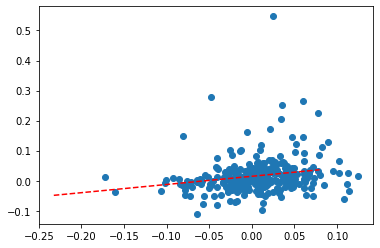

In [24]:
# linear regression plot
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LinearRegression().fit(X_train,y_train)
X_test = X_test.sort_values(by='Mkt-RF', ascending=True)
y_pred = model.predict(X_test)

plt.scatter(X_train,y_train)
plt.plot(X_test.to_numpy().flatten(), y_pred, color='r', linestyle='--')
plt.show()

In [25]:
x_train = sm.add_constant(X)
lm = sm.OLS(y,x_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               trt1m_ls   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.039
Method:                 Least Squares   F-statistic:                     16.50
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           5.91e-05
Time:                        23:42:02   Log-Likelihood:                 561.97
No. Observations:                 379   AIC:                            -1120.
Df Residuals:                     377   BIC:                            -1112.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0133      0.003      4.667      0.000       0.008       0.019
Mkt-RF         0.2522      0.062      4.062      0.000       0.130       0.374
==============================================================================
Omnibus:                      333.968   Durbin-Watson:                   1.529
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10883.237
Skew:                           3.540   Prob(JB):                         0.00
Kurtosis:                      28.279   Cond. No.                         21.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Fama French alpha**

In [26]:
X, y = df_capm[['Mkt-RF','SMB','HML']], df_capm['trt1m_ls']
x_train = sm.add_constant(X)
lm = sm.OLS(y,x_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               trt1m_ls   R-squared:                       0.309
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     55.97
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           6.44e-30
Time:                        23:42:02   Log-Likelihood:                 623.96
No. Observations:                 379   AIC:                            -1240.
Df Residuals:                     375   BIC:                            -1224.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0139      0.002      5.640      0.000       0.009       0.019
Mkt-RF         0.0971      0.056      1.746      0.082      -0.012       0.207
SMB            0.9252      0.083     11.156      0.000       0.762       1.088
HML           -0.1050      0.087     -1.201      0.231      -0.277       0.067
==============================================================================
Omnibus:                      184.670   Durbin-Watson:                   1.623
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1405.623
Skew:                           1.911   Prob(JB):                    5.93e-306
Kurtosis:                      11.626   Cond. No.                         40.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Sharpe Ratio**

In [27]:
r, s = df_capm['trt1m_ls'].mean(), df_capm['trt1m_ls'].std()
SR = (r/s) * math.sqrt(12)
SR

0.9074083387911033

# 3. Repeat steps 1 and 2 (calculating returns and alphas) using value-weighted returns for the portfolios (slides 26, 27)

In [28]:
merged_vw = merged.copy().drop(columns='r-rf')

In [29]:
df_vw = merged_vw[merged_vw.funda_date.dt.year.isin([x for x in range(1981, 2013)])].copy()

# market capital
df_vw['me'] = df_vw['prccm'] * df_vw['cshtrm']
df_vw['me_lag'] = df_vw['me'].shift(1)
df_vw = df_vw.dropna(subset='me_lag')

# market value return
df_vw['me_trt1m'] = df_vw['me_lag'] * (df_vw['trt1m']-df_vw['RF'])

In [30]:
me_ret = df_vw.groupby(['secm_date','quintile'])[['me_trt1m']].sum().reset_index()
me_ttl = df_vw.groupby(['secm_date', 'quintile'])[['me_lag']].sum().reset_index()

# weighted return by market capital
re = me_ret.merge(me_ttl, on=['secm_date','quintile'])
re['w_trt1m'] = re['me_trt1m']/re['me_lag']

df_vw = df_vw.merge(re, on=['secm_date','quintile'], how='left')

In [31]:
Q = ['L','2','3','4','H','N']

period = [(1981,2013), (1981,2000), (2000,2013)]
index = ['Full sample','Pre-2000','Post-2000']

table = pd.DataFrame(columns=['Periods', 'L','2','3','4','H','Non R&D'])
i = 0
for years in period:
    y0, y1 = years
    returns = []
    for quint in Q:
        subset = df_vw[(df_vw['funda_date'].dt.year.isin([x for x in range(y0,y1)])) & (df_vw['quintile'] == quint)]
        
        p_return = subset.groupby('secm_date')[['w_trt1m']].mean()
        
        res = p_return['w_trt1m'].mean()
        returns.append(round(res*100,3))
    table.loc[i] = [index[i]] + returns
    i += 1
table

,Periods,L,2,3,4,H,Non R&D
0,Full sample,0.696,0.700,0.693,0.812,1.188,0.284
1,Pre-2000,0.588,1.168,0.920,0.745,0.996,0.220
2,Post-2000,0.198,-0.140,0.311,0.595,1.011,0.070


In [32]:
long_v = df_vw[df_vw.quintile == 'H'].groupby('secm_date')[['w_trt1m']].mean()
short_v = df_vw[df_vw.quintile == 'L'].groupby('secm_date')[['w_trt1m']].mean()

long_v['year'] = long_v.index.year
long_v['month'] = long_v.index.month
short_v['year'] = short_v.index.year
short_v['month'] = short_v.index.month

In [33]:
ls_portfolio_v = long_v.merge(short_v, on=['year','month'],how='inner',suffixes=('_long','_short'))
ls_portfolio_v['w_trt1m_ls'] = ls_portfolio_v['w_trt1m_long'] - ls_portfolio_v['w_trt1m_short']
ls_portfolio_v = ls_portfolio_v.reset_index()
ls_portfolio_v = ls_portfolio_v[ls_portfolio_v.year < 2013]
ls_portfolio_v.head()

,index,w_trt1m_long,year,month,w_trt1m_short,w_trt1m_ls
0,0,-0.052646,1981,6,-0.131241,0.078595
1,1,-0.061557,1981,7,0.018654,-0.080211
2,2,-0.168662,1981,8,-0.138755,-0.029908
3,3,-0.038682,1981,9,-0.039632,0.000950
4,4,-0.004383,1981,10,0.101652,-0.106035


**CAPM alpha, value-weighted**

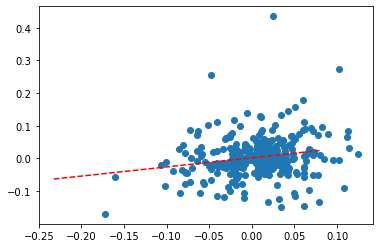

In [34]:
df_capm_v = ls_portfolio_v[['year','month','w_trt1m_ls']].merge(ff, on=['year','month'],how='left')
X, y = df_capm_v[['Mkt-RF']], df_capm_v['w_trt1m_ls']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LinearRegression().fit(X_train,y_train)
X_test = X_test.sort_values(by='Mkt-RF', ascending=True)
y_pred = model.predict(X_test)

plt.scatter(X_train,y_train)
plt.plot(X_test.to_numpy().flatten(), y_pred, color='r', linestyle='--')
plt.show()

In [35]:
x_train = sm.add_constant(X)
lm = sm.OLS(y,x_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             w_trt1m_ls   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     13.64
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           0.000254
Time:                        23:42:04   Log-Likelihood:                 509.92
No. Observations:                 379   AIC:                            -1016.
Df Residuals:                     377   BIC:                            -1008.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.003     -0.114      0.909      -0.007       0.006
Mkt-RF         0.2630      0.071      3.694      0.000       0.123       0.403
==============================================================================
Omnibus:                      112.037   Durbin-Watson:                   1.903
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              828.531
Skew:                           1.030   Prob(JB):                    1.22e-180
Kurtosis:                       9.944   Cond. No.                         21.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Fama-French alpha, value-weighted**

In [36]:
X, y = df_capm_v[['Mkt-RF','SMB','HML']], df_capm_v['w_trt1m_ls']
x_train = sm.add_constant(X)
lm = sm.OLS(y,x_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             w_trt1m_ls   R-squared:                       0.252
Model:                            OLS   Adj. R-squared:                  0.246
Method:                 Least Squares   F-statistic:                     42.04
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           1.92e-23
Time:                        23:42:05   Log-Likelihood:                 558.13
No. Observations:                 379   AIC:                            -1108.
Df Residuals:                     375   BIC:                            -1093.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0033      0.003     -1.138      0.256      -0.009       0.002
Mkt-RF         0.2401      0.066      3.628      0.000       0.110       0.370
SMB            0.9688      0.099      9.819      0.000       0.775       1.163
HML            0.6378      0.104      6.132      0.000       0.433       0.842
==============================================================================
Omnibus:                       41.596   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.121
Skew:                           0.326   Prob(JB):                     7.71e-40
Kurtosis:                       6.314   Cond. No.                         40.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Sharpe Ratio**

In [37]:
rv, sv = df_capm_v['w_trt1m_ls'].mean(), df_capm_v['w_trt1m_ls'].std()
SR_v = (rv/sv) * math.sqrt(12)
SR_v

0.059640389891561264

# 4. Repeat steps 1 and 2 (calculating returns and alphas)  excluding largest 1000 firms each year and using value-weighted returns for portfolios (slides 29, 30)

In [38]:
funda4 = df.copy()
funda4['year'] = funda4['datadate'].dt.year
funda4 = funda4[funda4['year'].isin([x for x in range(1981,2013)])]

# rank each company in each year, ascending (firm with largest market cap is the 1st)
funda4['rank'] = funda4.groupby('year')[['me']].rank(ascending=False)
# binary variable indicating whether a firm is in the top 1000 (1) or not (0)
funda4['largest1000'] = np.where(funda4['rank'] <= 1000, 1, 0)

# exclude largest 1000 firms each year
funda4 = funda4[funda4.largest1000 == 0]

In [39]:
# add quintiles
funda4['quintile'] = 'N'
df_temp = funda4[funda4['rdc_me'] != 0]

df_sm = funda4.copy().drop(columns=['rank','largest1000']).sort_values(by=['LPERMNO','datadate'])

years = df_temp.datadate.dt.year.unique()

for yr in years:
    df_sub = df_temp[df_temp.datadate.dt.year == yr]
    rnd_rank = df_sub[df_sub['rdc_me'] != 0]['rdc_me'].rank(ascending=True)
    quintile = pd.qcut(rnd_rank, 5, labels=['L','2','3','4','H'])
    df_sm.loc[quintile.index, 'quintile'] = quintile

df_sm.quintile.value_counts()

N    32602
L     6460
H     6455
2     6443
4     6442
3     6441
Name: quintile, dtype: int64

In [40]:
cols = ['secm_date', 'funda_date', 'LPERMNO', 'prccm', 'cshtrm', 'rdc_me', 'trt1m', 'RF', 'r-rf', 'quintile']
merged_sm = valid_secm.merge(df_sm, left_on=['funda_date','LPERMNO'],right_on=['datadate','LPERMNO'], how='left')
merged_sm = merged_sm.rename(columns={'datadate_x':'secm_date'})[cols]

merged_sm = merged_sm.dropna(subset='quintile')
merged_sm['me'] = merged_sm['prccm'] * merged_sm['cshtrm']

merged_sm['me_lag'] = merged_sm['me'].shift(1)
merged_sm = merged_sm.dropna(subset='me_lag')

# market value return
merged_sm['me_trt1m'] = merged_sm['me_lag'] * (merged_sm['trt1m']-merged_sm['RF'])

merged_sm

,secm_date,funda_date,LPERMNO,prccm,cshtrm,rdc_me,trt1m,RF,r-rf,quintile,me,me_lag,me_trt1m
1,1990-10-31,1990-06-30,10001,9.5000,6300.0,0.000000,-0.025641,0.0068,-0.032441,N,59850.00,118950.00,-3858.856950
2,1990-11-30,1990-06-30,10001,9.6250,20400.0,0.000000,0.013158,0.0057,0.007458,N,196350.00,59850.00,446.361300
3,1990-12-31,1990-06-30,10001,9.5000,10400.0,0.000000,0.001299,0.0060,-0.004701,N,98800.00,196350.00,-923.041350
4,1991-01-31,1990-06-30,10001,9.6250,38200.0,0.000000,0.013158,0.0052,0.007958,N,367675.00,98800.00,786.250400
5,1991-02-28,1990-06-30,10001,9.7500,24300.0,0.000000,0.012987,0.0048,0.008187,N,236925.00,367675.00,3010.155225
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1341622,1999-11-30,1999-06-30,93316,8.7500,80300.0,0.263051,0.272727,0.0036,0.269127,4,702625.00,116187.50,31269.193312
1341623,1999-12-31,1999-06-30,93316,12.8750,169500.0,0.263051,0.471429,0.0044,0.467029,4,2182312.50,702625.00,328146.251125
1341624,2000-01-31,1999-06-30,93316,15.1250,324000.0,0.263051,0.174757,0.0041,0.170657,4,4900500.00,2182312.50,372426.904313
1341625,2000-02-29,1999-06-30,93316,15.1563,391500.0,0.263051,0.002066,0.0043,-0.002234,4,5933691.45,4900500.00,-10947.717000


In [41]:
sm_me_ret = merged_sm.groupby(['secm_date','quintile'])[['me_trt1m']].sum().reset_index()
sm_me_ttl = merged_sm.groupby(['secm_date', 'quintile'])[['me_lag']].sum().reset_index()

re_sm = sm_me_ret.merge(sm_me_ttl, on=['secm_date','quintile'])
re_sm['w_trt1m'] = re_sm['me_trt1m']/re_sm['me_lag']

df_sm_vw = merged_sm.copy().merge(re_sm, on=['secm_date','quintile'], how='left')

df_sm_vw.head()

,secm_date,funda_date,LPERMNO,prccm,cshtrm,rdc_me,trt1m,RF,r-rf,quintile,me,me_lag_x,me_trt1m_x,me_trt1m_y,me_lag_y,w_trt1m
0,1990-10-31,1990-06-30,10001,9.500,6300.0,0.0,-0.025641,0.0068,-0.032441,N,59850.0,118950.0,-3858.856950,-1.062137e+08,9.855612e+08,-0.107770
1,1990-11-30,1990-06-30,10001,9.625,20400.0,0.0,0.013158,0.0057,0.007458,N,196350.0,59850.0,446.361300,4.984059e+06,1.455104e+09,0.003425
2,1990-12-31,1990-06-30,10001,9.500,10400.0,0.0,0.001299,0.0060,-0.004701,N,98800.0,196350.0,-923.041350,8.964220e+07,1.987920e+09,0.045093
3,1991-01-31,1990-06-30,10001,9.625,38200.0,0.0,0.013158,0.0052,0.007958,N,367675.0,98800.0,786.250400,1.008318e+08,1.060736e+09,0.095058
4,1991-02-28,1990-06-30,10001,9.750,24300.0,0.0,0.012987,0.0048,0.008187,N,236925.0,367675.0,3010.155225,1.665639e+08,1.533664e+09,0.108605


**repeat step 1, returns for the 3 periods**

In [42]:
Q = ['L','2','3','4','H','N']

period = [(1981,2013), (1981,2000), (2000,2013)]
index = ['Full sample','Pre-2000','Post-2000']

table = pd.DataFrame(columns=['Periods', 'L','2','3','4','H','Non R&D'])
i = 0
for years in period:
    y0, y1 = years
    returns = []
    for quint in Q:
        subset = df_sm_vw[(df_sm_vw['funda_date'].dt.year.isin([x for x in range(y0,y1)])) & (df_sm_vw['quintile'] == quint)]
        
        p_return = subset.groupby('secm_date')[['w_trt1m']].mean()
        res = p_return.w_trt1m.mean()
        returns.append(round(res*100,3))
    table.loc[i] = [index[i]] + returns
    i += 1
table

,Periods,L,2,3,4,H,Non R&D
0,Full sample,-0.081,0.544,0.374,0.655,2.053,0.371
1,Pre-2000,-0.284,0.583,0.558,0.467,1.633,0.116
2,Post-2000,-0.235,0.207,0.074,0.333,2.248,0.340


**repeat step 2**

In [43]:
long_v_sm = df_sm_vw[df_sm_vw.quintile == 'H'].groupby('secm_date')[['w_trt1m']].mean()
short_v_sm = df_sm_vw[df_sm_vw.quintile == 'L'].groupby('secm_date')[['w_trt1m']].mean()

long_v_sm['year'] = long_v_sm.index.year
long_v_sm['month'] = long_v_sm.index.month
short_v_sm['year'] = short_v_sm.index.year
short_v_sm['month'] = short_v_sm.index.month

In [44]:
ls_portfolio_v_sm = long_v_sm.merge(short_v_sm, on=['year','month'],how='inner',suffixes=('_long','_short'))
ls_portfolio_v_sm['w_trt1m_ls'] = ls_portfolio_v_sm['w_trt1m_long'] - ls_portfolio_v_sm['w_trt1m_short']
ls_portfolio_v_sm = ls_portfolio_v_sm.reset_index()
ls_portfolio_v_sm = ls_portfolio_v_sm[ls_portfolio_v_sm.year < 2013]
ls_portfolio_v_sm.head()

,index,w_trt1m_long,year,month,w_trt1m_short,w_trt1m_ls
0,0,0.140456,1981,6,-0.222995,0.363451
1,1,0.057314,1981,7,0.119363,-0.062049
2,2,-0.010284,1981,8,-0.086069,0.075785
3,3,-0.031357,1981,9,-0.185495,0.154138
4,4,0.185074,1981,10,0.129434,0.055640


**CAPM alpha**

In [45]:
df_capm_v_sm = ls_portfolio_v_sm[['year','month','w_trt1m_ls']].merge(ff, on=['year','month'],how='left')
X, y = df_capm_v_sm[['Mkt-RF']], df_capm_v_sm['w_trt1m_ls']

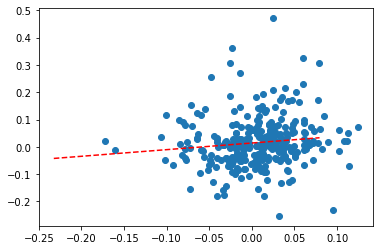

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LinearRegression().fit(X_train,y_train)

X_test = X_test.sort_values(by='Mkt-RF', ascending=True)
y_pred = model.predict(X_test)

plt.scatter(X_train,y_train)
plt.plot(X_test.to_numpy().flatten(), y_pred, color='r', linestyle='--')
plt.show()

In [47]:
x_train = sm.add_constant(X)
lm = sm.OLS(y,x_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             w_trt1m_ls   R-squared:                       0.022
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     8.522
Date:                Tue, 22 Nov 2022   Prob (F-statistic):            0.00372
Time:                        23:42:06   Log-Likelihood:                 376.23
No. Observations:                 379   AIC:                            -748.5
Df Residuals:                     377   BIC:                            -740.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0164      0.005      3.534      0.000       0.007       0.026
Mkt-RF         0.2958      0.101      2.919      0.004       0.097       0.495
==============================================================================
Omnibus:                       81.080   Durbin-Watson:                   1.677
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              216.890
Skew:                           1.014   Prob(JB):                     8.00e-48
Kurtosis:                       6.102   Cond. No.                         21.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Fama French alpha**

In [48]:
X, y = df_capm_v_sm[['Mkt-RF','SMB','HML']], df_capm_v_sm['w_trt1m_ls']
x_train = sm.add_constant(X)
lm = sm.OLS(y,x_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             w_trt1m_ls   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     9.769
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           3.21e-06
Time:                        23:42:07   Log-Likelihood:                 386.26
No. Observations:                 379   AIC:                            -764.5
Df Residuals:                     375   BIC:                            -748.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0169      0.005      3.657      0.000       0.008       0.026
Mkt-RF         0.1869      0.104      1.794      0.074      -0.018       0.392
SMB            0.6484      0.155      4.176      0.000       0.343       0.954
HML           -0.0751      0.164     -0.459      0.647      -0.397       0.247
==============================================================================
Omnibus:                       53.664   Durbin-Watson:                   1.682
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              113.387
Skew:                           0.755   Prob(JB):                     2.39e-25
Kurtosis:                       5.214   Cond. No.                         40.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Sharpe ratio**

In [49]:
rv_sm, sv_sm = df_capm_v_sm['w_trt1m_ls'].mean(), df_capm_v_sm['w_trt1m_ls'].std()
SR_v_sm = (rv_sm/sv_sm) * math.sqrt(12)
SR_v_sm

0.6907336544302244

# 5. Repeat steps 1-4 using an extended sample period thru Dec 2021

In [50]:
merged

,secm_date,funda_date,LPERMNO,prccm,cshtrm,rdc_me,trt1m,RF,r-rf,quintile
0,1990-09-30,1990-06-30,10001,9.750,12200.0,0.000000,0.040789,0.0060,0.034789,N
1,1990-10-31,1990-06-30,10001,9.500,6300.0,0.000000,-0.025641,0.0068,-0.032441,N
2,1990-11-30,1990-06-30,10001,9.625,20400.0,0.000000,0.013158,0.0057,0.007458,N
3,1990-12-31,1990-06-30,10001,9.500,10400.0,0.000000,0.001299,0.0060,-0.004701,N
4,1991-01-31,1990-06-30,10001,9.625,38200.0,0.000000,0.013158,0.0052,0.007958,N
...,...,...,...,...,...,...,...,...,...,...
1343206,2022-03-31,2021-12-31,93436,1077.600,574338380.0,0.005024,0.238009,0.0001,0.237909,L
1343207,2022-04-30,2021-12-31,93436,870.760,504164040.0,0.005024,-0.191945,0.0001,-0.192045,L
1343208,2022-05-31,2021-12-31,93436,758.260,646241450.0,0.005024,-0.129197,0.0003,-0.129497,L
1343209,2022-06-30,2021-12-31,93436,673.420,667890820.0,0.005024,-0.111888,0.0006,-0.112488,L


### 5.1 equal weight, 3 sample periods

In [51]:
Q = ['L','2','3','4','H','N']

period = [(1981,2022), (1981,2000), (2000,2022)]
index = ['Full sample','Pre-2000','Post-2000']

table = pd.DataFrame(columns=['Periods', 'L','2','3','4','H','Non R&D'])
i = 0
for years in period:
    y0, y1 = years
    returns = []
    for quint in Q:
        subset = merged[(merged['funda_date'].dt.year.isin([x for x in range(y0,y1)])) & (merged['quintile'] == quint)]
        
        p_return = subset.groupby('secm_date')[['r-rf']].mean()
        res = p_return['r-rf'].mean()
        returns.append(round(res*100,3))
    table.loc[i] = [index[i]] + returns
    i += 1

table

,Periods,L,2,3,4,H,Non R&D
0,Full sample,0.632,0.871,1.039,1.174,1.922,1.203
1,Pre-2000,0.292,0.893,0.866,1.749,1.173,0.286
2,Post-2000,0.764,0.867,1.035,0.950,1.630,1.288


In [52]:
all_portfolio = merged[merged.funda_date.dt.year.isin([x for x in range(1981,2022)])]
long = all_portfolio[all_portfolio.quintile == 'H'].groupby('secm_date')[['r-rf']].mean()
short = all_portfolio[all_portfolio.quintile == 'L'].groupby('secm_date')[['r-rf']].mean()

In [53]:
ls_portfolio = long.merge(short, on='secm_date',how='inner',suffixes=('_long','_short'))
ls_portfolio['trt1m_ls'] = ls_portfolio['r-rf_long'] - ls_portfolio['r-rf_short']
ls_portfolio = ls_portfolio.reset_index()
ls_portfolio['year'] = ls_portfolio['secm_date'].dt.year
ls_portfolio['month'] = ls_portfolio['secm_date'].dt.month
ls_portfolio.head()

,secm_date,r-rf_long,r-rf_short,trt1m_ls,year,month
0,1981-06-30,0.013384,-0.070461,0.083845,1981,6
1,1981-07-31,-0.059456,-0.090871,0.031415,1981,7
2,1981-08-31,-0.125898,-0.104222,-0.021676,1981,8
3,1981-09-30,-0.120406,-0.116745,-0.003661,1981,9
4,1981-10-31,0.086899,0.097905,-0.011007,1981,10


### 5.2 equal weight, long-short, CAPM alpha, Fama French alpha, and Sharpe ratio

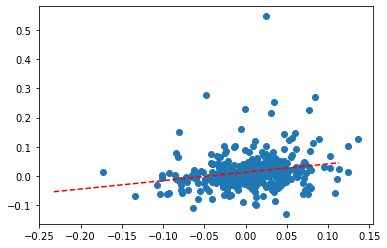

In [54]:
df_capm = ls_portfolio[['secm_date','year','month','trt1m_ls']].merge(ff, on=['year','month'],how='left')
X, y = df_capm[['Mkt-RF']], df_capm['trt1m_ls']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LinearRegression().fit(X_train,y_train)
X_test = X_test.sort_values(by='Mkt-RF', ascending=True)
y_pred = model.predict(X_test)

plt.scatter(X_train,y_train)
plt.plot(X_test.to_numpy().flatten(), y_pred, color='r', linestyle='--')
plt.show()

**CAPM alpha**

In [55]:
x_train = sm.add_constant(X)
lm = sm.OLS(y,x_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               trt1m_ls   R-squared:                       0.043
Model:                            OLS   Adj. R-squared:                  0.041
Method:                 Least Squares   F-statistic:                     22.30
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           3.04e-06
Time:                        23:42:09   Log-Likelihood:                 716.27
No. Observations:                 494   AIC:                            -1429.
Df Residuals:                     492   BIC:                            -1420.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0111      0.003      4.268      0.000       0.006       0.016
Mkt-RF         0.2687      0.057      4.722      0.000       0.157       0.380
==============================================================================
Omnibus:                      342.536   Durbin-Watson:                   1.604
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7302.289
Skew:                           2.691   Prob(JB):                         0.00
Kurtosis:                      21.050   Cond. No.                         22.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Fama French alpha**

In [56]:
X, y = df_capm[['Mkt-RF','SMB','HML']], df_capm['trt1m_ls']
x_train = sm.add_constant(X)
lm = sm.OLS(y,x_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               trt1m_ls   R-squared:                       0.280
Model:                            OLS   Adj. R-squared:                  0.276
Method:                 Least Squares   F-statistic:                     63.60
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           9.62e-35
Time:                        23:42:09   Log-Likelihood:                 786.55
No. Observations:                 494   AIC:                            -1565.
Df Residuals:                     490   BIC:                            -1548.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0120      0.002      5.280      0.000       0.008       0.016
Mkt-RF         0.1089      0.052      2.115      0.035       0.008       0.210
SMB            0.9417      0.078     12.047      0.000       0.788       1.095
HML           -0.1092      0.074     -1.469      0.143      -0.255       0.037
==============================================================================
Omnibus:                      168.936   Durbin-Watson:                   1.735
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              888.881
Skew:                           1.402   Prob(JB):                    9.59e-194
Kurtosis:                       8.943   Cond. No.                         37.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Sharpe Ratio**

In [57]:
r, s = df_capm['trt1m_ls'].mean(), df_capm['trt1m_ls'].std()
SR = (r/s) * math.sqrt(12)
SR

0.7695818366988689

### 5.3 value weight, repeat 5.1 and 5.2

In [58]:
merged_vw = merged.copy().drop(columns='r-rf')

In [59]:
df_vw = merged_vw.copy()
df_vw['me'] = df_vw['prccm'] * df_vw['cshtrm']

df_vw['me_lag'] = df_vw['me'].shift(1)
df_vw = df_vw.dropna(subset='me_lag')

# market value return
df_vw['me_trt1m'] = df_vw['me_lag'] * (df_vw['trt1m']-df_vw['RF'])

me_ret = df_vw.groupby(['secm_date','quintile'])[['me_trt1m']].sum().reset_index()
me_ttl = df_vw.groupby(['secm_date', 'quintile'])[['me_lag']].sum().reset_index()

re = me_ret.merge(me_ttl, on=['secm_date','quintile'])
re['w_trt1m'] = re['me_trt1m']/re['me_lag']

df_vw = df_vw.merge(re, on=['secm_date','quintile'], how='left')

In [60]:
Q = ['L','2','3','4','H','N']

period = [(1981,2022), (1981,2000), (2000,2022)]
index = ['Full sample','Pre-2000','Post-2000']

table = pd.DataFrame(columns=['Periods', 'L','2','3','4','H','Non R&D'])
i = 0
for years in period:
    y0, y1 = years
    returns = []
    for quint in Q:
        subset = df_vw[(df_vw['funda_date'].dt.year.isin([x for x in range(y0,y1)])) & (df_vw['quintile'] == quint)]
        
        p_return = subset.groupby('secm_date')[['w_trt1m']].mean()    
        res = p_return['w_trt1m'].mean()
        returns.append(round(res*100,3))
    table.loc[i] = [index[i]] + returns
    i += 1
table

,Periods,L,2,3,4,H,Non R&D
0,Full sample,0.725,1.064,0.832,0.953,0.987,0.575
1,Pre-2000,0.678,1.197,0.953,0.991,0.908,0.355
2,Post-2000,0.334,0.793,0.667,0.780,0.700,0.547


In [61]:
long_v = df_vw[df_vw.quintile == 'H'].groupby('secm_date')[['w_trt1m']].mean()
short_v = df_vw[df_vw.quintile == 'L'].groupby('secm_date')[['w_trt1m']].mean()

long_v['year'] = long_v.index.year
long_v['month'] = long_v.index.month
short_v['year'] = short_v.index.year
short_v['month'] = short_v.index.month

ls_portfolio_v = long_v.merge(short_v, on=['year','month'],how='inner',suffixes=('_long','_short'))
ls_portfolio_v['w_trt1m_ls'] = ls_portfolio_v['w_trt1m_long'] - ls_portfolio_v['w_trt1m_short']
ls_portfolio_v = ls_portfolio_v.reset_index()
ls_portfolio_v = ls_portfolio_v[ls_portfolio_v.year <= 2021]
ls_portfolio_v.head()

,index,w_trt1m_long,year,month,w_trt1m_short,w_trt1m_ls
0,0,-0.019117,1981,6,-0.129385,0.110267
1,1,-0.064562,1981,7,0.018654,-0.083216
2,2,-0.172533,1981,8,-0.152340,-0.020194
3,3,-0.039979,1981,9,-0.102875,0.062895
4,4,-0.010586,1981,10,0.123109,-0.133695


In [62]:
df_capm_v = ls_portfolio_v[['year','month','w_trt1m_ls']].merge(ff, on=['year','month'],how='left')
X, y = df_capm_v[['Mkt-RF']], df_capm_v['w_trt1m_ls']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LinearRegression().fit(X_train,y_train)
X_test = X_test.sort_values(by='Mkt-RF', ascending=True)
y_pred = model.predict(X_test)

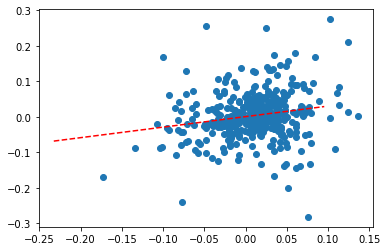

In [63]:
plt.scatter(X_train,y_train)
plt.plot(X_test.to_numpy().flatten(), y_pred, color='r', linestyle='--')
plt.show()

In [64]:
x_train = sm.add_constant(X)
lm = sm.OLS(y,x_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             w_trt1m_ls   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.033
Method:                 Least Squares   F-statistic:                     17.49
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           3.43e-05
Time:                        23:42:11   Log-Likelihood:                 612.90
No. Observations:                 487   AIC:                            -1222.
Df Residuals:                     485   BIC:                            -1213.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.003      0.316      0.752      -0.005       0.007
Mkt-RF         0.2930      0.070      4.182      0.000       0.155       0.431
==============================================================================
Omnibus:                      103.257   Durbin-Watson:                   2.022
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              694.573
Skew:                           0.725   Prob(JB):                    1.50e-151
Kurtosis:                       8.668   Cond. No.                         22.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
X, y = df_capm_v[['Mkt-RF','SMB','HML']], df_capm_v['w_trt1m_ls']
x_train = sm.add_constant(X)
lm = sm.OLS(y,x_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             w_trt1m_ls   R-squared:                       0.233
Model:                            OLS   Adj. R-squared:                  0.228
Method:                 Least Squares   F-statistic:                     48.88
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           1.33e-27
Time:                        23:42:11   Log-Likelihood:                 668.84
No. Observations:                 487   AIC:                            -1330.
Df Residuals:                     483   BIC:                            -1313.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0002      0.003     -0.082      0.935      -0.006       0.005
Mkt-RF         0.2116      0.065      3.253      0.001       0.084       0.339
SMB            1.0233      0.098     10.481      0.000       0.831       1.215
HML            0.5523      0.095      5.791      0.000       0.365       0.740
==============================================================================
Omnibus:                       40.429   Durbin-Watson:                   2.119
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              186.340
Skew:                           0.088   Prob(JB):                     3.44e-41
Kurtosis:                       6.025   Cond. No.                         37.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [66]:
rv, sv = df_capm_v['w_trt1m_ls'].mean(), df_capm_v['w_trt1m_ls'].std()
SR_v = (rv/sv) * math.sqrt(12)
SR_v

0.1551404693499753

### 5.4 value weight, exclude top 1000 firms, repeat 5.1 and 5.2

In [67]:
funda5 = df.copy()
funda5['year'] = funda5['datadate'].dt.year
funda5 = funda5[funda5['year'].isin([x for x in range(1981,2022)])]
funda5['rank'] = funda5.groupby('year')[['me']].rank(ascending=False)
funda5['largest1000'] = np.where(funda5['rank'] <= 1000, 1, 0)

funda5 = funda5[funda5.largest1000 == 0]

In [68]:
# add quintiles
funda4['quintile'] = 'N'
df_temp = funda5[funda5['rdc_me'] != 0]

df_sm = funda5.copy().drop(columns=['rank','largest1000']).sort_values(by=['LPERMNO','datadate'])

years = df_temp.datadate.dt.year.unique()

for yr in years:
    df_sub = df_temp[df_temp.datadate.dt.year == yr]
    rnd_rank = df_sub[df_sub['rdc_me'] != 0]['rdc_me'].rank(ascending=True)
    quintile = pd.qcut(rnd_rank, 5, labels=['L','2','3','4','H'])
    df_sm.loc[quintile.index, 'quintile'] = quintile

df_sm.quintile.value_counts()

N    37924
L     7861
H     7854
2     7839
3     7838
4     7838
Name: quintile, dtype: int64

In [69]:
cols = ['secm_date', 'funda_date', 'LPERMNO', 'prccm', 'cshtrm', 'rdc_me', 'trt1m', 'RF', 'r-rf', 'quintile']
merged_sm = valid_secm.merge(df_sm, left_on=['funda_date','LPERMNO'],right_on=['datadate','LPERMNO'], how='left')
merged_sm = merged_sm.rename(columns={'datadate_x':'secm_date'})[cols]

merged_sm = merged_sm.dropna(subset='quintile')
merged_sm['me'] = merged_sm['prccm'] * merged_sm['cshtrm']

merged_sm['me_lag'] = merged_sm['me'].shift(1)
merged_sm = merged_sm.dropna(subset='me_lag')

# market value return
merged_sm['me_trt1m'] = merged_sm['me_lag'] * (merged_sm['trt1m']-merged_sm['RF'])
merged_sm.head()

,secm_date,funda_date,LPERMNO,prccm,cshtrm,rdc_me,trt1m,RF,r-rf,quintile,me,me_lag,me_trt1m
1,1990-10-31,1990-06-30,10001,9.500,6300.0,0.0,-0.025641,0.0068,-0.032441,N,59850.0,118950.0,-3858.856950
2,1990-11-30,1990-06-30,10001,9.625,20400.0,0.0,0.013158,0.0057,0.007458,N,196350.0,59850.0,446.361300
3,1990-12-31,1990-06-30,10001,9.500,10400.0,0.0,0.001299,0.0060,-0.004701,N,98800.0,196350.0,-923.041350
4,1991-01-31,1990-06-30,10001,9.625,38200.0,0.0,0.013158,0.0052,0.007958,N,367675.0,98800.0,786.250400
5,1991-02-28,1990-06-30,10001,9.750,24300.0,0.0,0.012987,0.0048,0.008187,N,236925.0,367675.0,3010.155225


In [70]:
sm_me_ret = merged_sm.groupby(['secm_date','quintile'])[['me_trt1m']].sum().reset_index()
sm_me_ttl = merged_sm.groupby(['secm_date', 'quintile'])[['me_lag']].sum().reset_index()

re_sm = sm_me_ret.merge(sm_me_ttl, on=['secm_date','quintile'])
re_sm['w_trt1m'] = re_sm['me_trt1m']/re_sm['me_lag']

df_sm_vw = merged_sm.copy().merge(re_sm, on=['secm_date','quintile'], how='left')

In [71]:
Q = ['L','2','3','4','H','N']

period = [(1981,2022), (1981,2000), (2000,2022)]
index = ['Full sample','Pre-2000','Post-2000']

table = pd.DataFrame(columns=['Periods', 'L','2','3','4','H','Non R&D'])
i = 0
for years in period:
    y0, y1 = years
    returns = []
    for quint in Q:
        subset = df_sm_vw[(df_sm_vw['funda_date'].dt.year.isin([x for x in range(y0,y1)])) & (df_sm_vw['quintile'] == quint)]
        
        p_return = subset.groupby('secm_date')[['w_trt1m']].mean()
        res = p_return.w_trt1m.mean()
        returns.append(round(res*100,3))
    table.loc[i] = [index[i]] + returns
    i += 1
table

,Periods,L,2,3,4,H,Non R&D
0,Full sample,0.327,0.573,0.360,0.831,1.624,0.707
1,Pre-2000,-0.184,0.504,0.498,0.783,1.441,0.059
2,Post-2000,0.479,0.453,0.197,0.596,1.416,1.006


In [72]:
long_v_sm = df_sm_vw[df_sm_vw.quintile == 'H'].groupby('secm_date')[['w_trt1m']].mean()
short_v_sm = df_sm_vw[df_sm_vw.quintile == 'L'].groupby('secm_date')[['w_trt1m']].mean()

long_v_sm['year'] = long_v_sm.index.year
long_v_sm['month'] = long_v_sm.index.month
short_v_sm['year'] = short_v_sm.index.year
short_v_sm['month'] = short_v_sm.index.month

ls_portfolio_v_sm = long_v_sm.merge(short_v_sm, on=['year','month'],how='inner',suffixes=('_long','_short'))
ls_portfolio_v_sm['w_trt1m_ls'] = ls_portfolio_v_sm['w_trt1m_long'] - ls_portfolio_v_sm['w_trt1m_short']
ls_portfolio_v_sm = ls_portfolio_v_sm.reset_index()
ls_portfolio_v_sm = ls_portfolio_v_sm[ls_portfolio_v_sm.year <= 2021]
ls_portfolio_v_sm.head()

,index,w_trt1m_long,year,month,w_trt1m_short,w_trt1m_ls
0,0,0.086694,1981,6,-0.138537,0.225231
1,1,0.057314,1981,7,0.119363,-0.062049
2,2,-0.010284,1981,8,-0.116270,0.105986
3,3,-0.017700,1981,9,-0.200705,0.183005
4,4,0.193156,1981,10,0.071073,0.122084


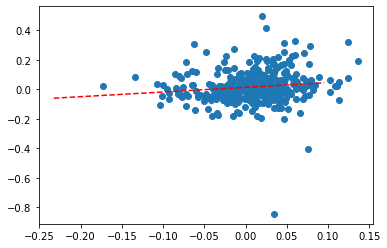

In [73]:
df_capm_v_sm = ls_portfolio_v_sm[['year','month','w_trt1m_ls']].merge(ff, on=['year','month'],how='left')
X, y = df_capm_v_sm[['Mkt-RF']], df_capm_v_sm['w_trt1m_ls']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model = LinearRegression().fit(X_train,y_train)
X_test = X_test.sort_values(by='Mkt-RF', ascending=True)
y_pred = model.predict(X_test)

plt.scatter(X_train,y_train)
plt.plot(X_test.to_numpy().flatten(), y_pred, color='r', linestyle='--')
plt.show()

In [74]:
x_train = sm.add_constant(X)
lm = sm.OLS(y,x_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             w_trt1m_ls   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     5.624
Date:                Tue, 22 Nov 2022   Prob (F-statistic):             0.0181
Time:                        23:42:14   Log-Likelihood:                 406.87
No. Observations:                 487   AIC:                            -809.7
Df Residuals:                     485   BIC:                            -801.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0119      0.005      2.455      0.014       0.002       0.021
Mkt-RF         0.2537      0.107      2.371      0.018       0.043       0.464
==============================================================================
Omnibus:                      122.657   Durbin-Watson:                   1.777
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2666.066
Skew:                          -0.488   Prob(JB):                         0.00
Kurtosis:                      14.421   Cond. No.                         22.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [75]:
X, y = df_capm_v_sm[['Mkt-RF','SMB','HML']], df_capm_v_sm['w_trt1m_ls']
x_train = sm.add_constant(X)
lm = sm.OLS(y,x_train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             w_trt1m_ls   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.043
Method:                 Least Squares   F-statistic:                     8.311
Date:                Tue, 22 Nov 2022   Prob (F-statistic):           2.13e-05
Time:                        23:42:14   Log-Likelihood:                 416.32
No. Observations:                 487   AIC:                            -824.6
Df Residuals:                     483   BIC:                            -807.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0123      0.005      2.586      0.010       0.003       0.022
Mkt-RF         0.1427      0.109      1.306      0.192      -0.072       0.357
SMB            0.6954      0.164      4.240      0.000       0.373       1.018
HML           -0.0372      0.160     -0.232      0.816      -0.352       0.278
==============================================================================
Omnibus:                      148.375   Durbin-Watson:                   1.803
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3135.258
Skew:                          -0.766   Prob(JB):                         0.00
Kurtosis:                      15.335   Cond. No.                         37.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
rv_sm, sv_sm = df_capm_v_sm['w_trt1m_ls'].mean(), df_capm_v_sm['w_trt1m_ls'].std()
SR_v_sm = (rv_sm/sv_sm) * math.sqrt(12)
SR_v_sm

0.44937430582737814